In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, ToPILImage, Resize, Compose
from torch import nn
from torch.nn import functional as F
from torchvision.models import vgg11, vgg16

In [2]:
import os
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from PIL import Image as pilimage

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from IPython.display import clear_output 

In [3]:
class Person:
    def __init__(self, name):
        self.name = name
        self.new = []
        self.old = []
        self.resize = Resize((224, 224))

    def add(self, age, num):
        pic = self.resize(
                  pilimage.open('../data/CACD2000/'+ str(age) + '_' + self.name + '_' + str(num) + '.jpg') #TODO format
              )
        if int(age) > 30:
            self.old.append(pic)
        else:
            self.new.append(pic)
            
    def get_old(self):
        return random.sample(self.old, 1)[0]
    def get_new(self):
        return random.sample(self.new, 1)[0]

In [4]:
import pickle

persons = {}

for pack in tqdm(os.listdir('../data/persons/')):
    with open('../data/persons/' + pack, 'rb') as f:
        dump = pickle.load(f)
        persons.update(dump)

In [5]:
identity_model = torch.load('../data/identity_model.pth')
identity_model.eval()
pass

In [6]:
for param in identity_model.parameters():
    param.requires_grad = False


In [7]:
age_model = torch.load('../data/age_model.pth')
age_model.eval()
pass

In [8]:
class AgeDataset(Dataset):
    def __init__(self, persons):
        self.persons = persons
        self.keys = list(persons.keys())
        
    def __len__(self):
        return len(self.persons) # 163446
    
    def __getitem__(self, ind):
        flag = 1
        while flag:
            pers = random.sample(self.keys, 1)[0]
            pers = persons[pers]
            try:
                new = pers.get_new()
                old = pers.get_old()
            except ValueError:
                continue
            flag = 0
        return ToTensor()(new), ToTensor()(old)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 9, 1, 4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.ress = nn.ModuleList([nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        ) for _ in range(4)])
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 12, 1, 4),
        )
    
    def forward(self, x): # херня с резблоками
        x = self.conv(x)
        for conv in self.ress:
            x = conv(x) + x
        return self.upconv(x)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = age_model.features
        self.path1 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        self.path2 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        self.path3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        self.path4 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.05),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        for param in self.features:
            param.requires_grad = False
        self.clf = nn.Linear(12*3, 1)
        
    def forward(self, x):
        conv_num = 0
        flag = 0
        results = []
        for module in self.features.modules():
            if flag == 0:
                flag += 1
                continue
            if isinstance(module, nn.Conv2d):
                conv_num+=1
                if conv_num == 2:
                    results.append(self.path4(x))
                if conv_num == 4:
                    results.append(self.path3(x))
                if conv_num == 7:
                    results.append(self.path2(x))
                if conv_num == 10:
                    results.append(self.path1(x))
            x = module(x)
        results = torch.cat(results, dim=1)
        return results
        # return self.clf(results.view(results.size(0), -1)).view(-1)

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
generator = Generator().apply(weights_init).cuda()
discriminator = Discriminator().apply(weights_init).cuda()

total_shape = 224*224*3

ageset = AgeDataset(persons)
ageloader = DataLoader(ageset, batch_size=8)

generator_optim = torch.optim.Adam(generator.parameters(), 1e-4, weight_decay=1)
discriminator_optim = torch.optim.Adam(discriminator.parameters(), 1e-4, weight_decay=1)

In [13]:
def adjust_w_decay(optimizer):
    state_dict = optimizer.state_dict()
    for param_group in state_dict['param_groups']:
        param_group['weight_decay'] = param_group['weight_decay'] * 0.5
    optimizer.load_state_dict(state_dict)

epoch  4 iter 100 total 250


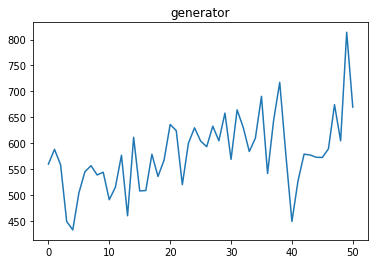

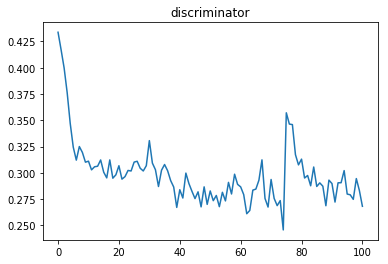

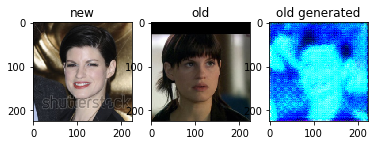

In [ ]:
for epoch in tqdm(range(300), desc='epoch'):
    gen_losses = []
    disc_losses = []
    
    adjust_w_decay(generator_optim)
    adjust_w_decay(discriminator_optim)
    
    generator.train()
    discriminator.train()
    for iter_ind, (new, old) in enumerate(tqdm(ageloader, leave=False, desc='train')):
        new, old = new.cuda(), old.cuda()
        
        if iter_ind % 2 == 0:
            generator_optim.zero_grad()
#             old_gen = generator(new)  # mb change
            disc_ans = discriminator(generator(new))
            identity_loss = 0.05 * torch.mean(torch.pow(F.pairwise_distance(identity_model(new), identity_model(generator(new))), 2))
            gen_loss = 750 * torch.mean(torch.pow(discriminator(generator(new)) - 1, 2))
            generator_loss = identity_loss + gen_loss
            if iter_ind % 10 == 0:
                objective_loss = 0.2 * torch.mean(torch.pow(torch.norm(generator(new) - new, dim=1), 2) / total_shape)
                generator_loss += objective_loss
            generator_loss.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 1)
            generator_optim.step()
            generator_optim.zero_grad()
            gen_losses.append(generator_loss.item())

        
        discriminator_optim.zero_grad()
        disc_loss = torch.mean(torch.pow(discriminator(old) - 1, 2)) * 0.5 + \
                    torch.mean(torch.pow(discriminator(generator(new).detach()), 2) + \
                               torch.pow(discriminator(new), 2)) * 0.5 
        disc_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
        discriminator_optim.step()
        discriminator_optim.zero_grad()
        disc_losses.append(disc_loss.item())
        
        # maybe one at a time?
        if iter_ind % 100 == 0 and iter_ind != 0:
            ageloader_eval = DataLoader(ageset, batch_size=1)
            clear_output()
            print('epoch ', epoch, 'iter', iter_ind, 'total', len(ageloader))
            plt.plot(gen_losses)
            plt.title('generator')
            plt.show()
            plt.plot(disc_losses)
            plt.title('discriminator')
            plt.show()
            generator.eval()
            discriminator.eval()
            new, old = next(iter(ageloader_eval))
            new = new.cuda()
            plt.subplot(1,3,1)
            plt.title('new')
            
            plt.imshow(new.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
            plt.subplot(1,3,2)
            plt.title('old')
            plt.imshow(old.data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
            plt.subplot(1,3,3)
            plt.title('old generated')
            plt.imshow(torch.clamp(generator(new), 0, 1).cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
            plt.show()


In [79]:
ageloader_eval = DataLoader(ageset, batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


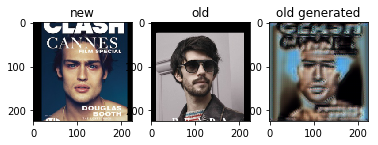

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


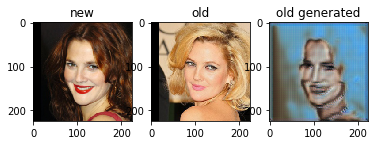

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


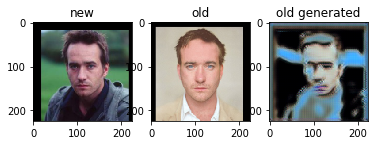

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


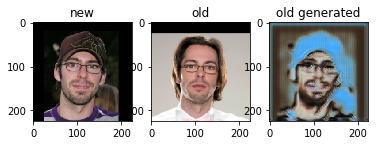

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


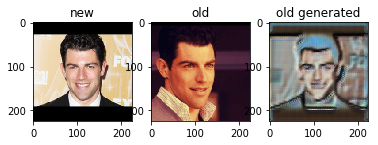

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


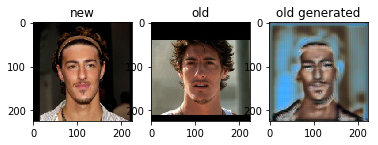

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


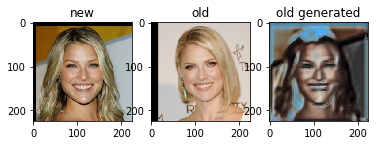

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


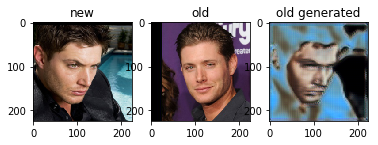

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


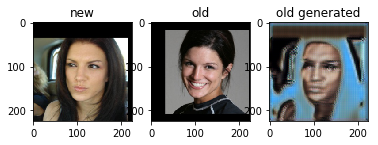

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


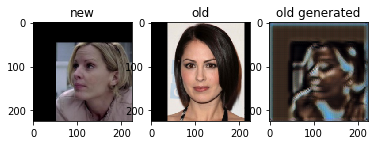

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


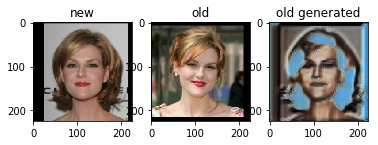

In [80]:
generator.eval()
discriminator.eval()
i = 0
for new, old in tqdm(ageloader_eval):
    i+=1
    new = new.cuda()
    old_gen = generator(new)
    plt.subplot(1,3,1)
    plt.title('new')
    plt.imshow(new.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.subplot(1,3,2)
    plt.title('old')
    plt.imshow(old.data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.subplot(1,3,3)
    plt.title('old generated')
    plt.imshow(old_gen.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.show()
    if i > 10:
        break

In [ ]:
1